# PerceptionLM: Open-Access Data and Models for Detailed Visual Understanding
Perception Language Model (PLM) is a state-of-the-art, fully open and reproducible MLLM for transparent research in image and video understanding.

[![Hugging Face Collection](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face%20Collection-Models,%20Data,%20and%20Benchmarks-blue)](https://huggingface.co/collections/facebook/perception-lm-67f9783f171948c383ee7498)
[![Paper](https://img.shields.io/badge/Technical%20Report-PerceptionLM-b31b1b.svg)](https://ai.meta.com/research/publications/perceptionlm-open-access-data-and-models-for-detailed-visual-understanding)
[![Paper](https://img.shields.io/badge/arXiv-2504.13180-brightgreen.svg?style=flat-square)](https://arxiv.org/abs/2504.13180)
[![ModelLicense](https://img.shields.io/badge/Model_License-FAIR_Research_License-lightgrey)](../../LICENSE.PLM)

### Login in HF hub

In [ ]:
from huggingface_hub.hf_api import HfFolder
# get your token here https://huggingface.co/settings/tokens
HfFolder.save_token('YOUR_HF_TOKEN')

In [134]:
import os
import re 

import torch
from PIL import Image, ImageDraw

import time
from IPython.display import HTML
from base64 import b64encode
import textwrap
import requests
import urllib.request

from core.args import dataclass_from_dict
from core.transforms.image_transform import get_image_transform
from core.transforms.video_transform import get_video_transform
from apps.plm.generate import PackedCausalTransformerGeneratorArgs, PackedCausalTransformerGenerator, load_consolidated_model_and_tokenizer

### Load PLM

In [148]:
# ckpt = "facebook/Perception-LM-1B"
# ckpt = "facebook/Perception-LM-3B" 
ckpt = "facebook/Perception-LM-8B" 
model, tokenizer, config = load_consolidated_model_and_tokenizer(ckpt)

Fetching 7 files:   0%|                                                                                                                                                                                                                                                                                                         | 0/7 [00:00<?, ?it/s]

Fetching 7 files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 61.09it/s]

Downloaded to: /home/janghyuncho7/.cache/huggingface/hub/models--facebook--Perception-LM-8B/snapshots/df40956519d6fe7cd26524baf55fc41d9e4cc1f9



INFO:apps.plm.tokenizer:Reloaded tiktoken model from /home/janghyuncho7/.cache/huggingface/hub/models--facebook--Perception-LM-8B/snapshots/df40956519d6fe7cd26524baf55fc41d9e4cc1f9/tokenizer.model
INFO:apps.plm.tokenizer:#words: 128256 - BOS ID: 128000 - EOS ID: 128001
INFO:apps.plm.transformer:Initializing PE_VisionTransformer with args: {'ls_init_value': 0.1, 'drop_path': 0.1, 'image_size': 448, 'patch_size': 14, 'width': 1536, 'layers': 47, 'heads': 16, 'mlp_ratio': 5.833333334, 'use_cls_token': False, 'use_abs_posemb': True, 'use_ln_post': False, 'pool_type': 'none'}


In [164]:
def generate(
    media_path,
    question="Describe the image in details.",
    media_type="image",
    number_of_frames=4,
    number_of_tiles=1,
    temperature=0.0,
    top_p=None,
    top_k=None,
    return_text=False,
):
    prompts = []
    if media_type == "image":
        transform = get_image_transform(
            vision_input_type=(
                "vanilla" if number_of_tiles == 1 else config.data.vision_input_type
            ),
            image_res=model.vision_model.image_size,
            max_num_tiles=number_of_tiles,
        )
        if isinstance(media_path, str):
            image = Image.open(media_path).convert("RGB")
        else:
            image = media_path
        image, _ = transform(image)
        prompts.append((question, image))
    elif media_type == "video":
        transform = get_video_transform(
            image_res=model.vision_model.image_size,
        )
        video_info = (media_path, number_of_frames, None, None, None)
        frames, _ = transform(video_info)
        prompts.append((question, frames))
    else:
        raise NotImplementedError(
            f"The provided generate function only supports image and video."
        )
    # Create generator
    gen_cfg = dataclass_from_dict(
        PackedCausalTransformerGeneratorArgs,
        {"temperature": temperature, "top_p": top_p, "top_k": top_k},
        strict=False,
    )
    generator = PackedCausalTransformerGenerator(gen_cfg, model, tokenizer)
    # Run generation
    start_time = time.time()
    generation, loglikelihood, greedy = generator.generate(prompts)
    end_time = time.time()
    if return_text:
        print(generation[0])
        return generation[0]
    
    for i, gen in enumerate(generation):
        # Calculate tokens per second
        total_tokens = sum(
            len(tokenizer.encode(gen, False, False)) for gen in generation
        )
        tokens_per_second = total_tokens / (end_time - start_time)
        print("=================================================")
        print(textwrap.fill(gen, width=75))
        print(f"Tokens per second: {tokens_per_second:.2f}")
        print("=================================================")

def extract_all_bounding_boxes(text: str) -> list[list[str]]:
    """Extracts any list of arbitrary length from a string."""
    pattern = r"\[\s*([^\[\]]*?)\s*\]"
    extracted_lists = [
        [num.strip() for num in match.split(",")] for match in re.findall(pattern, text)
    ]
    return extracted_lists

def rescale_2d_bboxes(bboxes, img_w, img_h, box_format="000", verbose=True):
    w, h = img_w, img_h
    rescaled_bboxes = []
    for bbox in bboxes:
        try:
            if box_format == "000":
                bbox = [float("0." + b.strip()) for b in bbox]
            elif box_format == "standard":
                bbox = [float(b.strip()) for b in bbox]
            else:
                # we don't know the format. try both
                try:
                    bbox = [float("0." + b.strip()) for b in bbox]
                except:
                    bbox = [float(b.strip()) for b in bbox]

            x1, y1, x2, y2 = bbox
            bbox = [x1 * w, y1 * h, x2 * w, y2 * h]

            rescaled_bboxes.append(bbox)
        except Exception as e:
            if verbose:
                print("[rescale_2d_bboxes]:", e, bbox, flush=True)
            pass
    return rescaled_bboxes

def postprocess_grounding(x: str, img_w: int, img_h: int) -> list[float]:
    bboxes = extract_all_bounding_boxes(x)
    bboxes = rescale_2d_bboxes(bboxes, img_w, img_h)
    if len(bboxes) > 0:
        box = bboxes[0]
    else:
        # no box found.
        box = [0, 0, img_w, img_h]
    return box


def generate_grounding(media_path: str, question: str, number_of_tiles: int):
    image = Image.open(media_path)
    w, h = image.size

    print("Generating...")
    output = generate(media_path=media_path, question=question, number_of_tiles=number_of_tiles, media_type="image", return_text=True)

    box = postprocess_grounding(output, w, h)

    draw = ImageDraw.Draw(image)
    try:
        x_min, y_min, x_max, y_max = box

        if x_min < x_max and y_min < y_max:
            # Draw the bounding box
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
    except Exception as e:
        print(f"Error drawing bounding box: {e}")
    return image

### Run inference for image grounding task

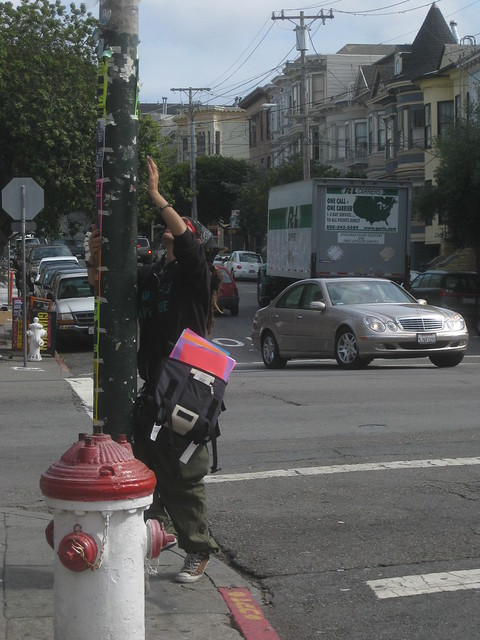

INFO:root:VariableSizeImageTransform size: 448
INFO:root:ImageTransform size: 448
INFO:root:Initalized transforms with: vision_input_type: 'thumb+tile' and max_num_tiles: 36.


Generating...
[040,482,112,576]


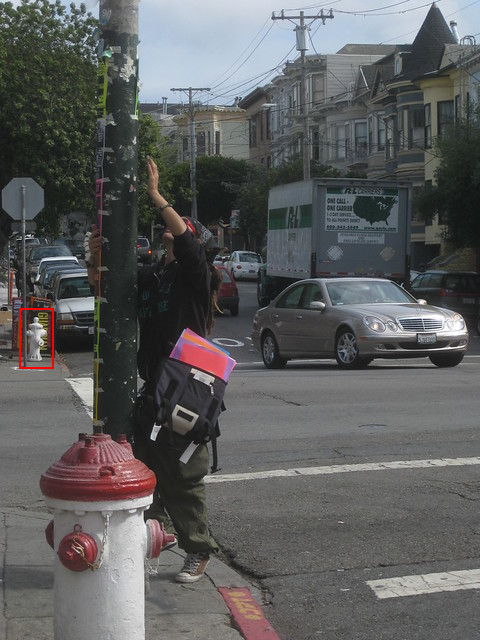

In [165]:
question_template = "Provide a bounding box of the region this sentence describes: '{caption}'.\nUse the format [x1, y1, x2, y2]."

image_url = "http://farm3.staticflickr.com/2453/3867429392_ed6f3d337a_z.jpg"
image_path = "3867429392_ed6f3d337a_z.jpg"

urllib.request.urlretrieve(image_url, image_path)

description = "white fire hydrant in the back"
question = question_template.format(caption=description)

img = Image.open(image_path)
display(img)

img_drawn = generate_grounding(media_path=image_path, question=question, number_of_tiles=36)
display(img_drawn)

### Region captioning (bounding box as text)

In [166]:
question = "Please describe the region ({bbox}) in details.\nThe region is in the format of [x1, y1, x2, y2]."
question = question.format(bbox="[040,482,112,576]")
generate(media_path=img_drawn, question=question, number_of_tiles=36, media_type="image")

INFO:root:VariableSizeImageTransform size: 448
INFO:root:ImageTransform size: 448
INFO:root:Initalized transforms with: vision_input_type: 'thumb+tile' and max_num_tiles: 36.


A white fire hydrant.
Tokens per second: 5.23


### Region captioning (bounding box as drawing)

In [167]:
question = "Please describe the region inside the rec rectangle."
generate(media_path=img_drawn, question=question, number_of_tiles=36, media_type="image")

INFO:root:VariableSizeImageTransform size: 448
INFO:root:ImageTransform size: 448
INFO:root:Initalized transforms with: vision_input_type: 'thumb+tile' and max_num_tiles: 36.


The image shows a white fire hydrant on the sidewalk.
Tokens per second: 8.93
